# Imports

In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import os
import pyrealsense2 as rs
import tkinter as tk

from PIL import Image
from scipy.interpolate import splprep, splev

# Class: Color Selector with GUI

In [20]:
class ColorSelector:
    
    def __init__(self):
        # Create the main window
        self.root = tk.Tk()

        # Set the window title and size
        self.root.title("Color Selector")
        self.root.geometry("340x170")

        # Center the window on the screen
        self.root.eval('tk::PlaceWindow %s center' % self.root.winfo_toplevel())

        # Create four buttons with different background colors and styles
        self.red_button = tk.Button(self.root, text="Red", bg="red", command=self.select_red, font=("Helvetica", 16), width=10, height=2)
        self.orange_button = tk.Button(self.root, text="Orange", bg="orange", command=self.select_orange, font=("Helvetica", 16), width=10, height=2)
        self.green_button = tk.Button(self.root, text="Green", bg="green", command=self.select_green, font=("Helvetica", 16), width=10, height=2)
        self.yellow_button = tk.Button(self.root, text="Yellow", bg="yellow", command=self.select_yellow, font=("Helvetica", 16), width=10, height=2)

        # Pack the buttons into the window using the grid layout manager
        self.red_button.grid(row=0, column=0, padx=10, pady=10)
        self.orange_button.grid(row=0, column=1, padx=10, pady=10)
        self.green_button.grid(row=1, column=0, padx=10, pady=10)
        self.yellow_button.grid(row=1, column=1, padx=10, pady=10)

    # Method to select the "red" color
    def select_red(self):
        self.root.destroy()
        self.color = "red"

    # Method to select the "orange" color
    def select_orange(self):
        self.root.destroy()
        self.color = "orange"

    # Method to select the "green" color
    def select_green(self):
        self.root.destroy()
        self.color = "green"

    # Method to select the "yellow" color
    def select_yellow(self):
        self.root.destroy()
        self.color = "yellow"

    # Method to show the color selector window and return the selected color
    def get_color(self):
        self.color = None
        self.root.mainloop()
        return self.color

# Function: Search desired color type and return x,y pixel coordinates

In [21]:
class ColorImage:

    def __init__(self, color):
        self.brightness_value = 60
        self.saturation_value = 70
        self.color = color
        self.folder_path = "images/" 

    def getTreshold(self):

        "This function detects the biggest area of a color in the image and returns the center of the area in pixel coordinates."

        # define the lower and upper boundaries of the colors in the HSV color space

        if self.color=="red":
            lower_value = np.array([149, 84, 57], dtype = "uint8") 
            upper_value= np.array([179, 255, 255], dtype = "uint8")

        if self.color=="yellow":
            lower_value = np.array([15, 84, 151], dtype = "uint8") 
            upper_value= np.array([27, 255, 255], dtype = "uint8")

        if self.color=="orange":
            lower_value = np.array([0, 135, 99], dtype = "uint8") 
            upper_value= np.array([13, 255, 255], dtype = "uint8")

        if self.color=="green":
            lower_value = np.array([30, 62, 0], dtype = "uint8") 
            upper_value= np.array([86, 255, 255], dtype = "uint8")

        return lower_value, upper_value
    
    def startStream(self):
        
        # Configure color streams
        pipeline = rs.pipeline()
        config = rs.config()
        config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

        # Start streaming
        pipeline.start(config)

        # Set the brightness and saturation of the camera
        color_sensor = pipeline.get_active_profile().get_device().first_color_sensor()
        color_sensor.set_option(rs.option.brightness, self.brightness_value)
        color_sensor.set_option(rs.option.saturation, self.saturation_value)

        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()

        # Convert images to numpy arrays
        color_image = np.asanyarray(color_frame.get_data())

        # Stop streaming
        pipeline.stop()

        return color_image

    def getClassicalMask(self, color_image, lower_value, upper_value):

        hsv = cv2.cvtColor(color_image, cv2.COLOR_BGR2HSV)    # convert to HSV
        mask = cv2.inRange(hsv, lower_value, upper_value)  # mask for color

        kernel = np.ones((15,15),np.uint8)  # 15x15 kernel for morphological transformation
        opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        kernel = np.ones((5,5),np.uint8)  # 20x20 kernel for morphological transformation
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
        classical_mask = closing

        return classical_mask
    
    def getPixelCoordinates(self, mask, color_image):
        
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # find contours
        biggest_contour = max(contours, key = cv2.contourArea) # find the biggest contour (c) by the area

        # find the center of the contour
        M = cv2.moments(biggest_contour)
        x_pixelkoordinate = int(M['m10']/M['m00'])
        y_pixelkoordinate = int(M['m01']/M['m00'])

        # find the spline
        tck, u = splprep(biggest_contour[:,0,:].T, s=0.0)    
        u_new = np.linspace(u.min(), u.max(), 1000) 
        x_new, y_new = splev(u_new, tck, der=0)

        # Create the "images" folder if it doesn't exist
        os.makedirs(self.folder_path, exist_ok=True)

        # Determine the next image number
        existing_images = os.listdir(self.folder_path)
        current_image_number = len(existing_images) + 1

        # Define the filename with the current image number
        filename = f"image_{current_image_number}.jpg"

        # Show the original image with the contour
        image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.plot(x_new, y_new, 'r')
        plt.plot(x_pixelkoordinate, y_pixelkoordinate, 'bo') 

        # Save the plot image in the "images" folder with the filename
        plt.savefig(os.path.join(self.folder_path, filename))

        return x_pixelkoordinate, y_pixelkoordinate

# Calling the function

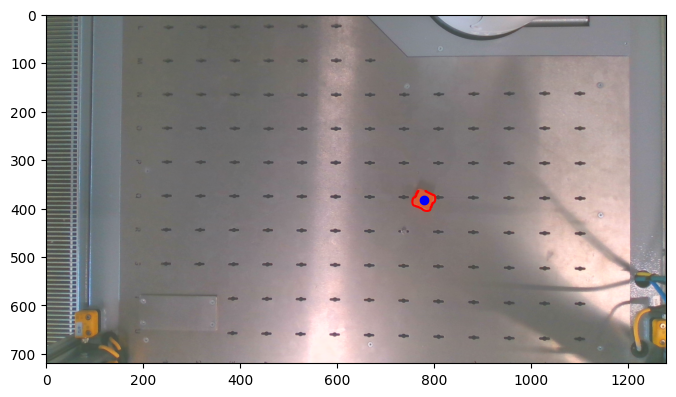

In [22]:
color_selector = ColorSelector()
selected_color = color_selector.get_color()

image = ColorImage(selected_color)
lower_value, upper_value = image.getTreshold()
color_image = image.startStream()
classical_mask = image.getClassicalMask(color_image, lower_value, upper_value)

x_pixelkoordinate, y_pixelkoordinate = image.getPixelCoordinates(classical_mask, color_image)

# From given pixel coordinates, calculate x,y,z coordinates in camera frame

In [23]:
class depthImage:

    def __init__(self, x_pixelkoordinate, y_pixelkoordinate):
        self.x_pixelkoordinate = x_pixelkoordinate
        self.y_pixelkoordinate = y_pixelkoordinate
        
    def startDepthStream(self):
        # Initialize RealSense pipeline and get depth sensor intrinsics
        pipeline = rs.pipeline()
        config = rs.config()
        config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
        profile = pipeline.start(config)

        return pipeline, profile
        
    def get3DCoordinates(self, pipeline, profile):
        depth_sensor = profile.get_device().first_depth_sensor()
        depth_scale = depth_sensor.get_depth_scale()
        intrinsics = profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()

        # Define the range of pixels to consider around the desired pixel
        pixel_range = 3

        # Read a depth frame and get a pixel coordinate
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        depth_image = np.asanyarray(depth_frame.get_data())

        pixel = (self.x_pixelkoordinate, self.y_pixelkoordinate)  # example pixel coordinate

        # Get the depth values for the pixels in the specified range
        depth_values = []
        for i in range(pixel[1] - pixel_range, pixel[1] + pixel_range + 1):
            for j in range(pixel[0] - pixel_range, pixel[0] + pixel_range + 1):
                if i >= 0 and i < depth_image.shape[0] and j >= 0 and j < depth_image.shape[1]:
                    depth_values.append(depth_image[i, j])

        # Compute the median depth value
        median_depth_value = np.median(depth_values)

        # Deproject pixel to 3D point in camera coordinates
        point_3d = rs.rs2_deproject_pixel_to_point(intrinsics, pixel, median_depth_value)

        x_cameraFrame = point_3d[0]/1000
        y_cameraFrame = point_3d[1]/1000
        z_cameraFrame = point_3d[2]/1000

        print("x: ", x_cameraFrame)
        print("y: ", y_cameraFrame)
        print("z: ", z_cameraFrame)

        # Stop streaming
        pipeline.stop()

        return x_cameraFrame, y_cameraFrame, z_cameraFrame

In [24]:
depthImage = depthImage(x_pixelkoordinate, y_pixelkoordinate)
pipeline, profile = depthImage.startDepthStream()
x_cameraFrame, y_cameraFrame, z_cameraFrame = depthImage.get3DCoordinates(pipeline, profile)

x:  0.10349109649658203
y:  0.017517099380493163
z:  0.646
